Ex. 1
1. In the first exercise you will implement a version of the OddBall algorithm discussed in the course. You will first load the dataset from
the ca-AstroPh.txt file (each line contains an edge of the graph) and
build the corresponding undirected graph using networkx.Graph. Each
appearance of an edge in the dataset will increase the weight of the
edge by one (you can store the weight for each edge with a key using
G[node1][node2][”weight”] = weight).

In [4]:
import networkx as nx
file_path = 'ca-AstroPh.txt'
G = nx.Graph()
with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        if i >= 1500:
            break
        nodes = line.strip().split()
        if len(nodes) == 2:
            node1, node2 = nodes
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += 1
            else:
                G.add_edge(node1, node2, weight=1)
                
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 1100
Number of edges: 1455


2. Extract the four features from the egonet (subgraph consisting of all neigh-
bours) corresponding to each node: \
• Ni - number of neighbors \
• Ei - number of edges in egonet i \
• Wi - total weight of egonet i \
• λw, i - principal eigenvalue of the weighted adjacency matrix of egonet i \
Store the features in the Graph object using nx.set node attributes

In [5]:
import numpy as np

features = {}
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    egonet = G.subgraph(neighbors + [node])
    Ni = len(neighbors)
    Ei = egonet.number_of_edges()
    Wi = sum(data['weight'] for u, v, data in egonet.edges(data=True))
    adjacency_matrix = nx.to_numpy_array(egonet, weight='weight')
    eigenvalues = np.linalg.eigvals(adjacency_matrix)
    lambda_w_i = max(eigenvalues).real  

    features[node] = {
        'Ni': Ni,
        'Ei': Ei,
        'Wi': Wi,
        'lambda_w_i': lambda_w_i
    }
nx.set_node_attributes(G, features)

for node, attrs in list(G.nodes(data=True))[:5]:
    print(f"Node {node}: {attrs}")


Node 84424: {'Ni': 75, 'Ei': 84, 'Wi': 87, 'lambda_w_i': 9.452271536378053}
Node 276: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_w_i': 1.0}
Node 1662: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_w_i': 1.0}
Node 5089: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_w_i': 1.0}
Node 6058: {'Ni': 2, 'Ei': 2, 'Wi': 2, 'lambda_w_i': 1.414213562373095}


3. Compute the anomaly score for each node by fitting a LinearRegres-
sion model (from sklearn.linear model) with the logarithmic scale of the
2 features (Ei and Ni - which should detect near-cliques and stars). The
anomaly score will be:
scorei = max(yi, Cxiθ )
min(yi, Cxiθ ) log(|yi − Cxiθ | + 1)
given the power-law equation y = Cxθ

In [6]:
from sklearn.linear_model import LinearRegression
import math

Ei = np.array([G.nodes[node]['Ei'] for node in G.nodes()])
Ni = np.array([G.nodes[node]['Ni'] for node in G.nodes()])
log_Ni = np.log(Ni)
log_Ei = np.log(Ei)

X = log_Ni.reshape(-1, 1)
y = log_Ei
model = LinearRegression().fit(X, y)
C = np.exp(model.intercept_)
theta = model.coef_[0]

anomaly_scores = {}
for i, node in enumerate(G.nodes()):
    predicted_yi = C * Ni[i] ** theta
    score = (
            max(Ei[i], predicted_yi) / min(Ei[i], predicted_yi)
        ) * math.log(abs(Ei[i] - predicted_yi) + 1)
    anomaly_scores[node] = score

nx.set_node_attributes(G, anomaly_scores, 'anomaly_score')


4. Sort the scores of the nodes in descending order and draw the graph using
nx.draw(). Using the node color parameter for the specified function,
draw the nodes corresponding to the biggest 10 scores with a different
color. Use just the first 1500 rows from the file when generating the
graph

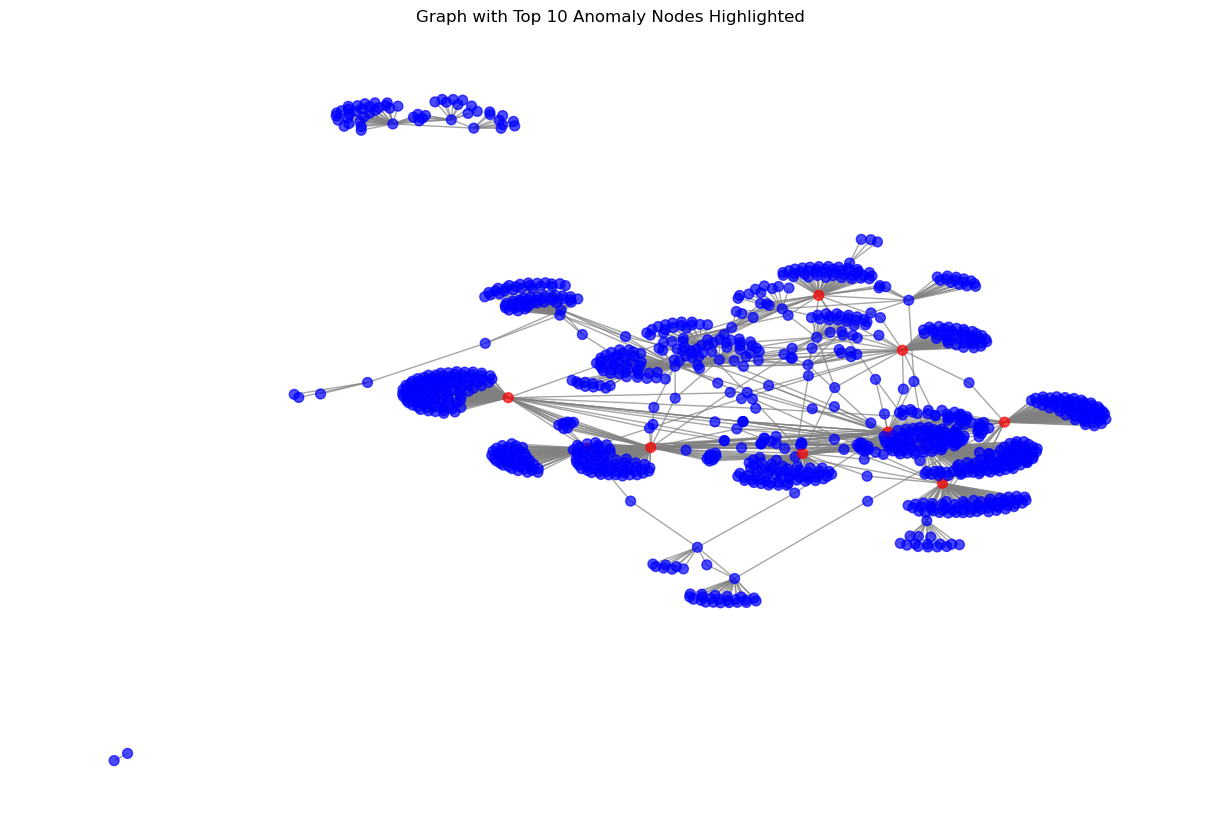

In [7]:
import matplotlib.pyplot as plt

sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1].get('anomaly_score', 0), reverse=True)
top_10_nodes = {node for node, _ in sorted_nodes[:10]}

node_colors = [
    'red' if node in top_10_nodes else 'blue' for node in G.nodes()
    ]

plt.figure(figsize=(12, 8))
nx.draw(
    G, 
    node_color=node_colors, 
    with_labels=False, 
    node_size=50, 
    edge_color='gray', 
    alpha=0.7
  )
plt.title("Graph with Top 10 Anomaly Nodes Highlighted")
plt.show()


5. Modify the anomaly score as the sum of the normalized score that was
computed earlier and the score obtained by LOF (for the pair of Ei and
Ni features) and draw again the graph using a different color for the nodes
corresponding to the biggest 10 scores

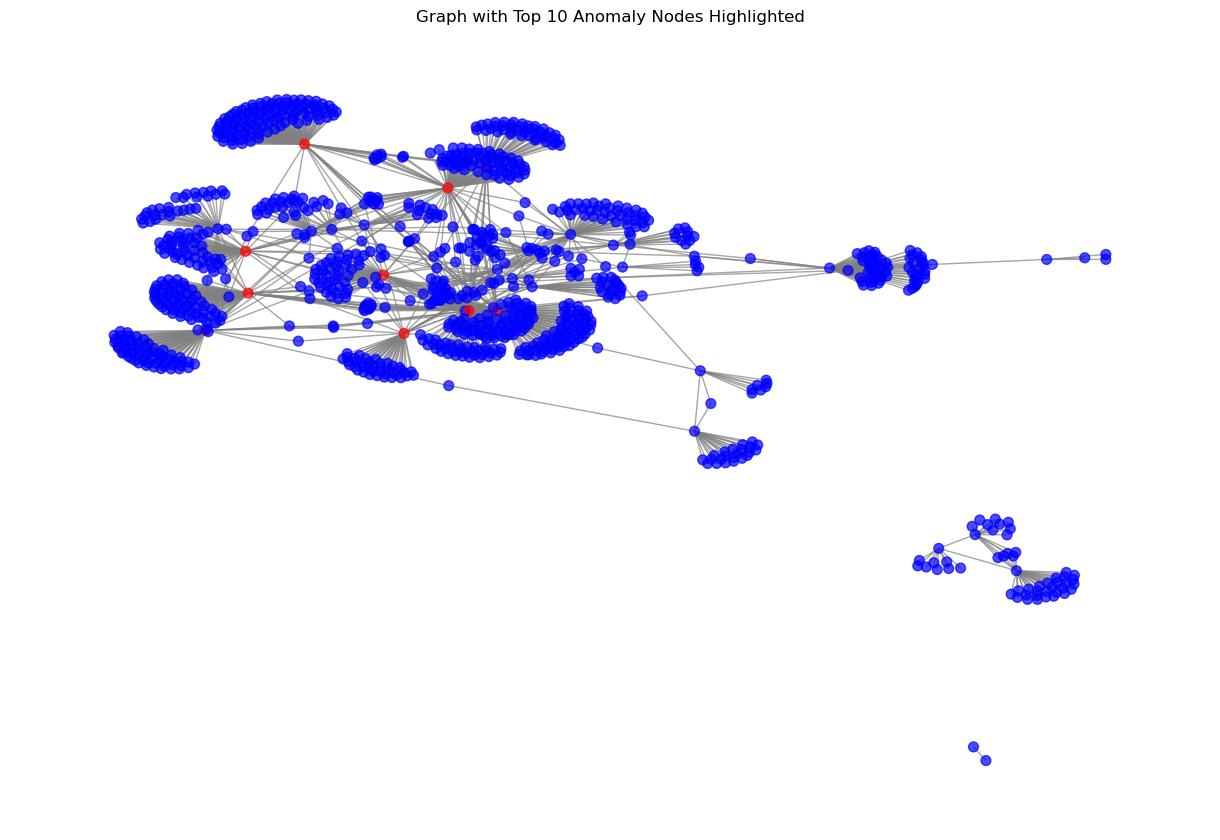

In [8]:
from sklearn.neighbors import LocalOutlierFactor

Ei = np.array([G.nodes[node]['Ei'] for node in G.nodes()])
Ni = np.array([G.nodes[node]['Ni'] for node in G.nodes()])
X = np.column_stack((Ei, Ni))

lof = LocalOutlierFactor(n_neighbors=20, metric='euclidean')
lof_scores = -lof.fit_predict(X)
max_lof = max(lof_scores)
min_lof = min(lof_scores)
normalized_lof_scores = (lof_scores - min_lof) / (max_lof - min_lof)
    
combined_scores = {}
for i, node in enumerate(G.nodes()):
    normalized_anomaly_score = G.nodes[node].get('anomaly_score', 0)
    combined_scores[node] = normalized_anomaly_score + normalized_lof_scores[i]

nx.set_node_attributes(G, combined_scores, 'combined_anomaly_score')


sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1].get('combined_anomaly_score', 0), reverse=True)
top_10_nodes = {node for node, _ in sorted_nodes[:10]}

node_colors = [
    'red' if node in top_10_nodes else 'blue' for node in G.nodes()
    ]

plt.figure(figsize=(12, 8))
nx.draw(
    G, 
    node_color=node_colors, 
    with_labels=False, 
    node_size=50, 
    edge_color='gray', 
    alpha=0.7
  )
plt.title("Graph with Top 10 Anomaly Nodes Highlighted")
plt.show()


Ex. 2
1. In this exercise we will generate some types of graph anomalies using net-
workx package. You will first generate a regular graph with 100 nodes where each one will have a degree 3 using networkx.random regular graph.
You will merge it with another graph that will contain 10 cliques with 20
nodes each. This one will be generated using networkx.connected caveman graph().
Both will be merged using networkx.union() and some random edges
will be added in order to build a connected graph. Draw the resulted
graph. Use the model developed in the first exercise to detect the first 10
nodes that are most probably part of a clique in the final merged graph
(using Ei and Ni) and draw them using a different color

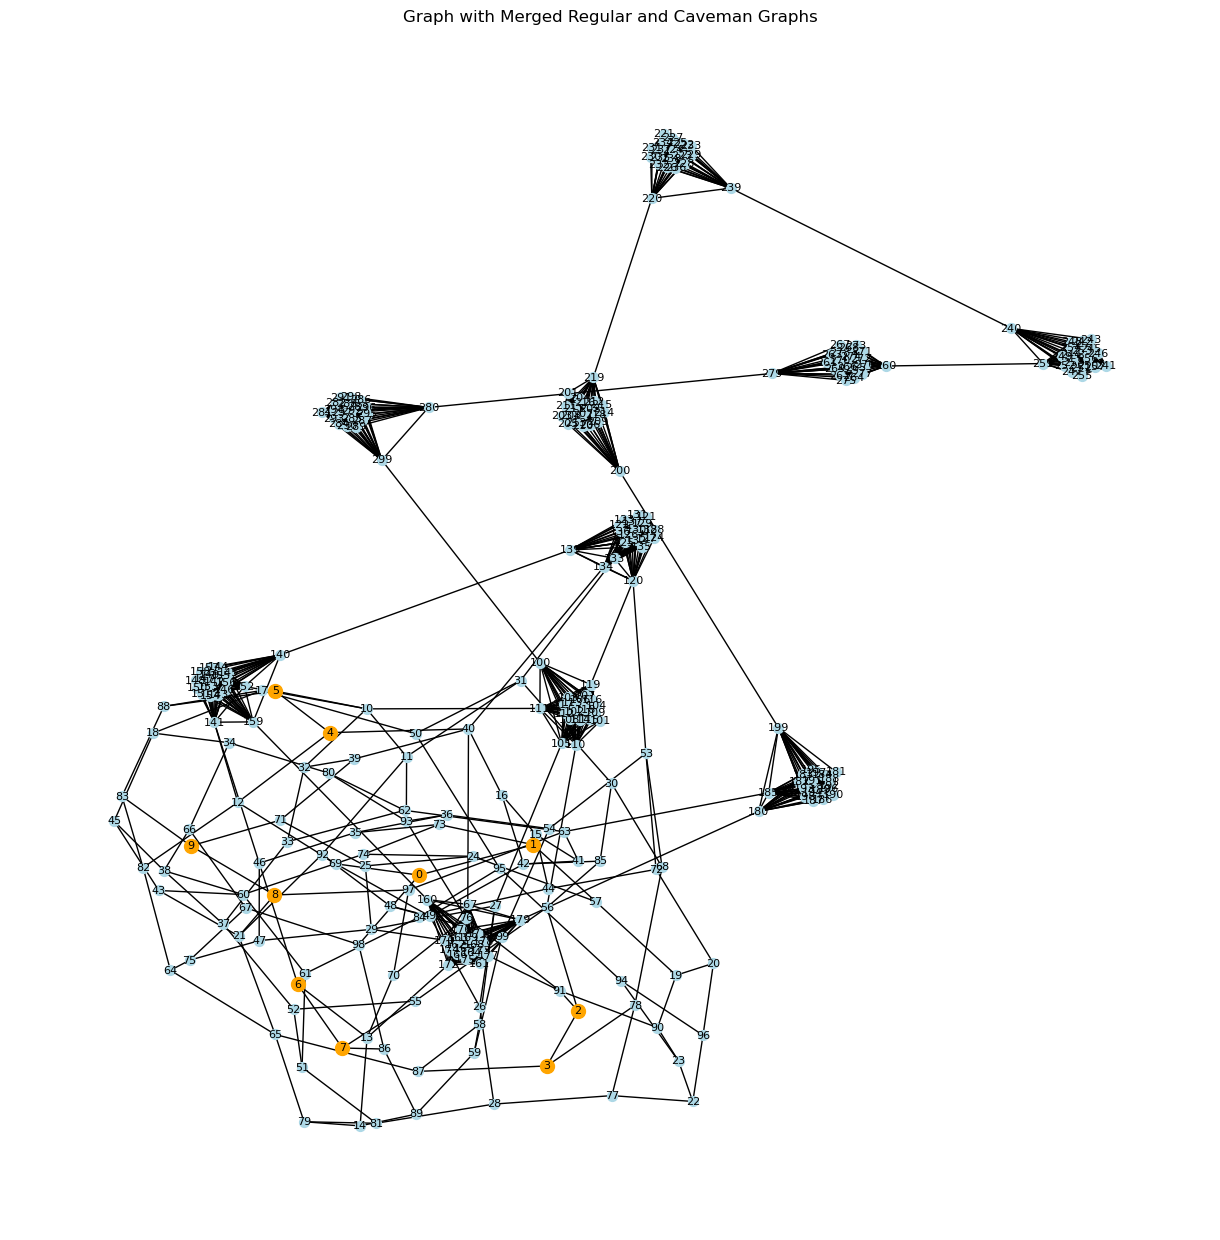

In [11]:
import random

G1 = nx.random_regular_graph(3, 100)
G2 = nx.connected_caveman_graph(10, 20)
G = nx.disjoint_union(G1, G2)
nodes_G1 = list(G1.nodes())
nodes_G2 = list(G2.nodes())
for _ in range(20):
    node1 = random.choice(nodes_G1)
    node2 = random.choice(nodes_G2)
    G.add_edge(node1, node2)

clique_scores = []
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    num_neighbors = len(neighbors)
    num_edges = sum(1 for neighbor in neighbors if node in G.neighbors(neighbor))
    score = num_edges / num_neighbors if num_neighbors > 0 else 0
    clique_scores.append((node, score))

clique_scores.sort(key=lambda x: x[1], reverse=True)
top_10_clique_nodes = [node for node, _ in clique_scores[:10]]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=50, with_labels=True, font_size=8, node_color='lightblue')
nx.draw_networkx_nodes(G, pos, nodelist=top_10_clique_nodes, node_color='orange', node_size=100)
plt.title("Graph with Merged Regular and Caveman Graphs")
plt.show()


2. Here you will generate some HeavyVicinity anomalies. You will gener-
ate a regular graph with 100 nodes where each one will have a degree 3
and another one that has 100 nodes and each member node has degree 5
(using networkx.random regular graph). You will merge them using
networkx.union() and then you will assign weight 1 for each edge using
G.add edge(edge[0], edge[1], weight=1) while iterating over all the
edges. You will pick 2 random nodes and you will add 10 to the weights
of all the edges from their egonets (using G[node1][node2][”weight”]
+= 10). Then you will use the same model to draw with a different color
the 4 nodes that have the greatest score (using Wi and Ei - which should
detect the heavy vicinities).

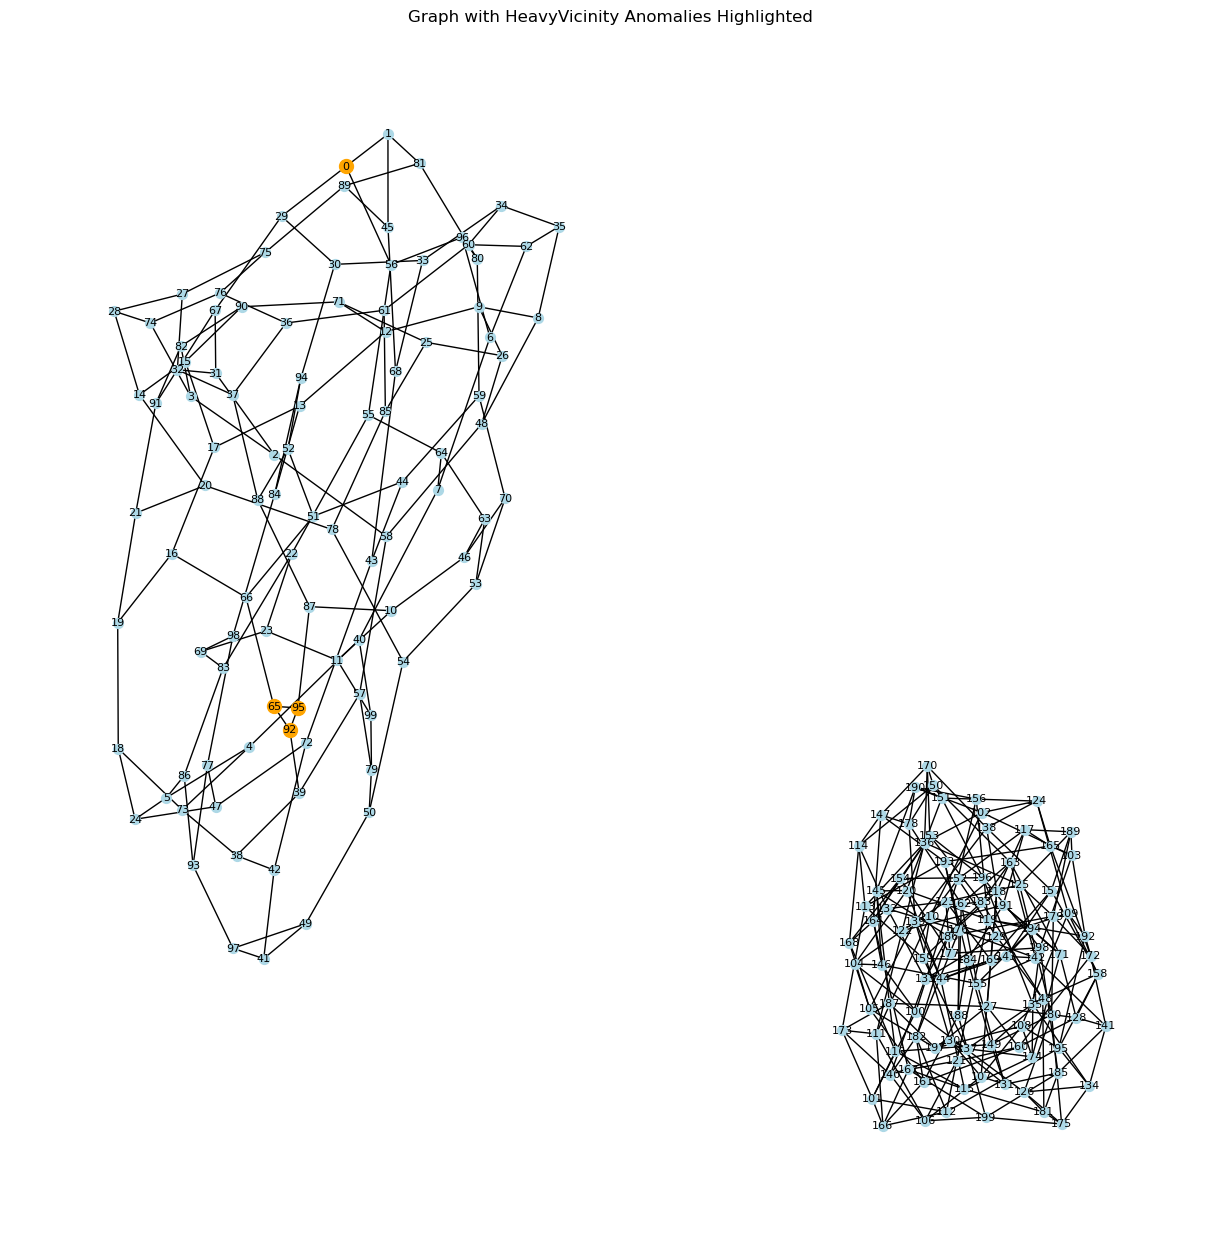

In [14]:
G1 = nx.random_regular_graph(3, 100)  
G2 = nx.random_regular_graph(5, 100) 
G = nx.disjoint_union(G1, G2)

for edge in G.edges():
    G.add_edge(edge[0], edge[1], weight=1)

node1, node2 = random.sample(list(G.nodes()), 2)

def increase_weights(node):
    for neighbor in G.neighbors(node):
        for neighbor_of_neighbor in G.neighbors(neighbor):
            if G.has_edge(node, neighbor_of_neighbor):
                G[node][neighbor_of_neighbor]['weight'] += 10

increase_weights(node1)
increase_weights(node2)

scores = []
for node in G.nodes():
    weight_sum = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
    degree = len(list(G.neighbors(node)))
    score = weight_sum / (degree if degree > 0 else 1)
    scores.append((node, score))

scores.sort(key=lambda x: x[1], reverse=True)
top_4_nodes = [node for node, _ in scores[:4]]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=50, with_labels=True, font_size=8, node_color='lightblue')
nx.draw_networkx_nodes(G, pos, nodelist=top_4_nodes, node_color='orange', node_size=100)
plt.title("Graph with HeavyVicinity Anomalies Highlighted")
plt.show()
